This notebook should be processed after the initial pre-processing of the dev data


In [ ]:
# TODO:
# 多线程优化

# 找到一些其他的数据集，然后实践，看泛化性
# 情感方向（广一些）

# 看 percentage, 改阈值
# CLIP为 plan b (too much...)

# 看单个case的近义词，不删除，但是cluster
# | <- 分隔符

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sys

# use only for dictionary parsing...
import ast

# 0. Review: synonyms detection
## synonymNet
https://arxiv.org/abs/1901.00056https://arxiv.org/abs/1901.00056

Being able to automatically discover synonymous entities in an open-world setting benefits various tasks such as entity disambiguation or knowledge graph canonicalization. Existing works either only utilize entity features, or rely on structured annotations from a single piece of context where the entity is mentioned. To leverage diverse contexts where entities are mentioned, in this paper, we generalize the distributional hypothesis to a multi-context setting and propose a synonym discovery framework that detects entity synonyms from free-text corpora with considerations on effectiveness and robustness. As one of the key components in synonym discovery, we introduce a neural network model SYNONYMNET to determine whether or not two given entities are synonym with each other. Instead of using entities features, SYNONYMNET makes use of multiple pieces of contexts in which the entity is mentioned, and compares the context-level similarity via a bilateral matching schema. Experimental results demonstrate that the proposed model is able to detect synonym sets that are not observed during training on both generic and domain-specific datasets: Wiki+Freebase, PubMed+UMLS, and MedBook+MKG, with up to 4.16% improvement in terms of Area Under the Curve and 3.19% in terms of Mean Average Precision compared to the best baseline method.Being able to automatically discover synonymous entities in an open-world setting benefits various tasks such as entity disambiguation or knowledge graph canonicalization. Existing works either only utilize entity features, or rely on structured annotations from a single piece of context where the entity is mentioned. To leverage diverse contexts where entities are mentioned, in this paper, we generalize the distributional hypothesis to a multi-context setting and propose a synonym discovery framework that detects entity synonyms from free-text corpora with considerations on effectiveness and robustness. As one of the key components in synonym discovery, we introduce a neural network model SYNONYMNET to determine whether or not two given entities are synonym with each other. Instead of using entities features, SYNONYMNET makes use of multiple pieces of contexts in which the entity is mentioned, and compares the context-level similarity via a bilateral matching schema. Experimental results demonstrate that the proposed model is able to detect synonym sets that are not observed during training on both generic and domain-specific datasets: Wiki+Freebase, PubMed+UMLS, and MedBook+MKG, with up to 4.16% improvement in terms of Area Under the Curve and 3.19% in terms of Mean Average Precision compared to the best baseline method.

In [3]:
import synonyms

smart_open library not found; falling back to local-filesystem-only
[jieba] default dict file path ..\data\vocab.txt
[jieba] default dict file path ..\data\vocab.txt
[jieba] load default dict ..\data\vocab.txt ...
[jieba] load default dict ..\data\vocab.txt ...
>> Synonyms load wordseg dict [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\vocab.txt] ... 
>> Synonyms on loading stopwords [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\stopwords.txt] ...
[Synonyms] on loading vectors [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\words.vector.gz] ...


In [6]:
# 中文还行
print("开心: ", synonyms.nearby("开心"))
print("伤心: ", synonyms.nearby("伤心"))
print("NOT_EXIST: ", synonyms.nearby("NOT_EXIST"))

开心:  (['开心', '高兴', '兴奋', '愉快', '难过', '快乐', '伤心', '痛快', '尽兴', '得意'], [1.0, 0.80510014, 0.7370683, 0.7110831, 0.7060874, 0.69482696, 0.67555505, 0.65788877, 0.6525332, 0.64982194])
伤心:  (['伤心', '难过', '心痛', '悲伤', '悲痛', '悔恨', '心疼', '郁闷', '悲愤', '忐忑'], [1.0, 0.87252134, 0.8377604, 0.82897615, 0.7907454, 0.75183433, 0.7486311, 0.7461942, 0.7386005, 0.7325378])
NOT_EXIST:  ([], [])


In [7]:
# 英文寄了
print("happy: ", synonyms.nearby("happy"))
print("sad: ", synonyms.nearby("sad"))

happy:  (['happy', 'Let', 'is', 'This', 'all', 'it', 'To', 'fame', 'spend', 'creates'], [1.0, 0.6119284, 0.5868017, 0.5624877, 0.5546613, 0.5529554, 0.5517211, 0.5055882, 0.49800324, 0.46012384])
sad:  (['sad', 'failing', 'esta', 'initially', 'Though', 'defend', 'returning', 'fame', 'begun', 'proved'], [1.0, 0.5269767, 0.52678764, 0.5045616, 0.49744284, 0.49625623, 0.4941613, 0.4784833, 0.4747744, 0.4695003])


## NLTK - wordnet

In [4]:
from nltk.corpus import wordnet

In [9]:
wordnet.synsets('happy')

[Synset('happy.a.01'),
 Synset('felicitous.s.02'),
 Synset('glad.s.02'),
 Synset('happy.s.04')]

In [71]:
def wordNetCheck(wordInput):
    # Then, we're going to use the term "program" to find synsets like so:
    syns = wordnet.synsets(wordInput)

    # An example of a synset:
    print(syns[0].name())

    # Just the word:
    print(syns[0].lemmas()[0].name())

    # Definition of that first synset:
    print(syns[0].definition())

    # Examples of the word in use in sentences:
    print(syns[0].examples(), "\n")

In [73]:
wordNetCheck('happy')

wordNetCheck('glad')

happy.a.01
happy
enjoying or showing or marked by joy or pleasure
['a happy smile', 'spent many happy days on the beach', 'a happy marriage'] 

gladiolus.n.01
gladiolus
any of numerous plants of the genus Gladiolus native chiefly to tropical and South Africa having sword-shaped leaves and one-sided spikes of brightly colored funnel-shaped flowers; widely cultivated
[] 



We can use this framework to find possible synonyms & antonyms

In [75]:
import nltk
from nltk.corpus import wordnet
synonyms = []
antonyms = []
for syn in wordnet.synsets("happy"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())
  
print(set(synonyms))
print(set(antonyms))

list(x.antonyms()[0].name() for y in wordnet.synsets("glad") for x in y.lemmas() if x.antonyms())


{'felicitous', 'well-chosen', 'glad', 'happy'}
{'unhappy'}


['sad']

Method 1：

Create undirected weighted graph and find link or path


👇

Method 2：

use wordNet definition of each emotion to find context similarities


## 0.1 Using wordnet to calculate weight

In [86]:
def calculateRelavancyUsingWordNet(e1, e2, threshold):
    """
    This function using BFS to calculate the potential weight of 2 emotion
    
    @param e1:        represents a emotion
    @param e2:        represents a emotion
    @param threshold: store the maximum score allowed for 2 emotion(usually <= 3)
    e.g. 1. we expected score == 0 when e1 == e2
    
         2. we expected 0 <= score <= threshold when e1 -> e2 is highly related
            else score = MAX_INT
    """
    
    # invalid input
    if (e1.count(" ") > 0 or e2.count(" ") > 0):
        print("Warning: \""+ e1 + "\" or \"" + e2 + "\" is not a word")
    if (threshold <= 0):
        raise Exception("Error: invalid threshold")
    
    # case: same, no need to analyze
    if (e1 == e2): return 0;

    # case: normal, start limited BFS
    visited = [e1]
    queue = [e1]
    level = [[] for i in range(threshold)]
    level[0].append(e1)
    while queue:
        currentEmotion = queue.pop(0)
        for neighbour in np.unique(list(emotion.name() for allrelated in wordnet.synsets(currentEmotion) for emotion in allrelated.lemmas())):
            if neighbour not in visited:
                level[[currentEmotion in x for x in level].index(True) + 1].append(neighbour) # get parent's level to set neighbour to a proper pos
                visited.append(neighbour)
                queue.append(neighbour)
            if (neighbour == e2):
                print("Success: BFS level-of-nodes report for \"{}\": {}\n".format(e1, level))
                return len([nested for nested in level if nested]) - 1
        
        if ([currentEmotion in x for x in level].index(True) + 1 >= threshold or not queue): # case: exceed threshold or every node reach leaf
            print("Failed: BFS level-of-nodes report for \"{}\": {}\n".format(e1, level))
            return sys.maxsize

In [87]:
print("expected: {}, get: {}".format(1, calculateRelavancyUsingWordNet("happy", "glad", 4)))
print("expected: {}, get: {}".format("sys max int", calculateRelavancyUsingWordNet("unhappy", "happy", 4)))
print("expected: {}, get: {}".format(0, calculateRelavancyUsingWordNet("sad", "sad", 4)))

Success: BFS level-of-nodes report for "happy": [['happy'], ['felicitous', 'glad'], [], []]

expected: 1, get: 1
Failed: BFS level-of-nodes report for "unhappy": [['unhappy'], ['distressed', 'dysphoric', 'infelicitous'], ['disquieted', 'distress', 'disturbed', 'hard-pressed', 'hard_put', 'in_a_bad_way', 'straiten', 'stressed', 'upset', 'worried'], ['cark', 'disorder', 'disquiet', 'distract', 'perturb', 'trouble', 'unhinge', 'distraint', 'hurt', 'suffering', 'agitate', 'brainsick', 'commove', 'crazy', 'demented', 'disturb', 'interrupt', 'mad', 'maladjusted', 'raise_up', 'shake_up', 'sick', 'stir_up', 'touch', 'unbalanced', 'unhinged', 'vex', 'accent', 'accented', 'accentuate', 'emphasise', 'emphasize', 'punctuate', 'strain', 'stress', 'try', 'bowl_over', 'broken', 'confused', 'derangement', 'discomfit', 'discompose', 'disconcert', 'disordered', 'disturbance', 'knock_over', 'overthrow', 'overturn', 'overturned', 'perturbation', 'swage', 'tip_over', 'tump_over', 'turn_over', 'turnover', '

# 1. Modify processed dataset

In [88]:
dataDevEmotionMultipleSentence = pd.read_csv('dev/emotion/allcharlinepairs-withoutPlutchikVoting-v1.csv')
dataDevEmotionMultipleSentence['emotion'] = [list(x.strip('[').strip(']').strip('\"').strip().replace("\", \"", ", ").replace("\'", "").split(', ')) 
                              for x in dataDevEmotionMultipleSentence['emotion']]
dataDevEmotionMultipleSentence['plutchik'] = [ast.literal_eval(x) for x in dataDevEmotionMultipleSentence['plutchik']]

dataDevEmotionMultipleSentence = dataDevEmotionMultipleSentence.drop(labels='Unnamed: 0',axis=1)
dataDevEmotionMultipleSentence.index.names = ['index']
dataDevEmotionMultipleSentence = dataDevEmotionMultipleSentence.reset_index()
dataDevEmotionMultipleSentence

,index,storyid,linenum,char,emotionworkerid,context,sentence,affected,emotion,plutchik
0,0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann0,NaN,I began making fish curry for my boyfriend and I.,yes,"[joy, excited]","{'joy': 3, 'trust': 3, 'surprise': 3, 'anticip..."
1,1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann1,NaN,I began making fish curry for my boyfriend and I.,yes,[content],{'joy': 2}
2,2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann2,NaN,I began making fish curry for my boyfriend and I.,yes,"[hungry, anticipation]","{'joy': 2, 'anticipation': 3}"
3,3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),ann1,I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,[excited],"{'joy': 3, 'trust': 3, 'anticipation': 3}"
4,4,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),ann2,I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,[confident],"{'joy': 2, 'trust': 3, 'anticipation': 2}"
...,...,...,...,...,...,...,...,...,...,...
42947,42947,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,4,Marcus,ann1,Marcus was collecting shells on the beach.|He ...,Suddenly he felt a sharp pinch.,yes,[sore],"{'joy': 2, 'trust': 2, 'fear': 2, 'sadness': 3..."
42948,42948,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,4,Marcus,ann2,Marcus was collecting shells on the beach.|He ...,Suddenly he felt a sharp pinch.,yes,[surprised],"{'joy': 2, 'fear': 2, 'surprise': 3, 'anticipa..."
42949,42949,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,ann0,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,[shocked],"{'fear': 2, 'surprise': 3, 'anticipation': 3}"
42950,42950,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,5,Marcus,ann1,Marcus was collecting shells on the beach.|He ...,A crab was inside the shell pinching his leg.,yes,[surprised],"{'fear': 2, 'surprise': 3, 'anticipation': 2}"


In [89]:
# set the dataframe going to analyzed
currentAnalyze = dataDevEmotionMultipleSentence

# Modified plutchik analyze
## 2.1 Standard plutchik(including no emotion case)

In [90]:
for index, row in currentAnalyze.iterrows():
    tempalteOrder = {'joy' : 0, 'trust' : 0, 'fear' : 0, 'surprise' : 0, 'sadness' : 0, 'disgust' : 0, 'anger' : 0, 'anticipation' : 0}
    for key, value in row['plutchik'].items():
        tempalteOrder[key] = value
    currentAnalyze['plutchik'][index] = tempalteOrder.copy()
    print("\r", end="")
    print("2.1 Standard plutchik(including no emotion case) -> start conversion, current progress: {}/{} ".format(index+1, currentAnalyze.shape[0]), end="")

2.1 Standard plutchik(including no emotion case) -> start conversion, current progress: 42952/42952 

### 2.2 Modify emotion

In [91]:
currentAnalyze['emotion'] = currentAnalyze.emotion.map(lambda x: {emotion : 1 for emotion in x })

### 2.3 Voting

In [92]:
# EMOTION 加一个weight，表达程度
# 确认同义词的定义（一个人是否同时说happy, glad...）
mainPosIndex = []
for index, row in currentAnalyze.iterrows():
    if (index == 0 or currentEditting['sentence'] != row['sentence']): # case: new sentence, update CURRENT adding
        if (index != 0):
            for key in currentEditting['plutchik']:
                # print(index - currentEditting[0], "previous: ", currentEditting[1]['plutchik'][key])
                currentEditting['plutchik'][key] //= index - currentEditting[0]
            for i in range(currentEditting['index'] + 1, index):
                for emotion in currentAnalyze['emotion'][i]:
                    currentAnalyze['emotion'][currentEditting['index']][emotion] = currentAnalyze['emotion'][currentEditting['index']].get(emotion, 0) + 1 
        currentEditting = currentAnalyze.iloc[index]
        mainPosIndex.append(currentEditting['index'])
    else: # case: same as previous sentence, do voting
        for key, value in currentAnalyze['plutchik'][index].items():
            currentAnalyze['plutchik'][currentEditting['index']][key] += value
    print("\r", end="")
    print("2.2 Voting -> start voting, current progress: {}/{} ".format(index+1, currentAnalyze.shape[0]), end="")
    
# dealing last case
for key in currentEditting['plutchik']:
    # print(index - currentEditting[0], "previous: ", currentEditting[1]['plutchik'][key])
    currentEditting['plutchik'][key] //= index - currentEditting[0]
for i in range(currentEditting['index'] + 1, index):
    for emotion in currentAnalyze['emotion'][i]:
        currentAnalyze['emotion'][currentEditting['index']][emotion] = currentAnalyze['emotion'][currentEditting['index']].get(emotion, 0) + 1 

2.2 Voting -> start voting, current progress: 42952/42952 

In [93]:
currentAnalyze = currentAnalyze[pd.Series([x in mainPosIndex for x in currentAnalyze['index']], index = currentAnalyze.index)]
currentAnalyze = currentAnalyze.drop(labels='index',axis=1)
currentAnalyze = currentAnalyze.reset_index(drop=True)
currentAnalyze.index.names = ['index']
currentAnalyze = currentAnalyze.reset_index()

In [94]:
currentAnalyze

,index,storyid,linenum,char,emotionworkerid,context,sentence,affected,emotion,plutchik
0,0,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,1,I (myself),ann0,NaN,I began making fish curry for my boyfriend and I.,yes,"{'joy': 1, 'excited': 1, 'content': 1, 'hungry...","{'joy': 2, 'trust': 1, 'fear': 0, 'surprise': ..."
1,1,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,2,I (myself),ann1,I began making fish curry for my boyfriend and I.,I decided not to read a recipe since I've made...,yes,"{'excited': 1, 'confident': 1}","{'joy': 2, 'trust': 3, 'fear': 0, 'surprise': ..."
2,2,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,3,I (myself),ann0,I began making fish curry for my boyfriend and...,I let the curry sit before tasting.,yes,"{'anxious': 1, 'confident': 1, 'positive': 1}","{'joy': 1, 'trust': 1, 'fear': 0, 'surprise': ..."
3,3,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,4,I (myself),ann1,I began making fish curry for my boyfriend and...,"When it was time to taste, I was disgusted.",yes,"{'upset': 1, 'sick': 1}","{'joy': 0, 'trust': 0, 'fear': 1, 'surprise': ..."
4,4,a2ddbb50-e45b-4ad3-becf-b2d8475172bf,5,I (myself),ann1,I began making fish curry for my boyfriend and...,I accidentally used a whole garlic instead of ...,yes,"{'disgusted': 1, 'cretinous': 1}","{'joy': 0, 'trust': 0, 'fear': 0, 'surprise': ..."
...,...,...,...,...,...,...,...,...,...,...
11605,11605,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,1,Marcus,ann0,NaN,Marcus was collecting shells on the beach.,yes,"{'intrigued': 1, 'happy': 1, 'contemplative': 1}","{'joy': 3, 'trust': 1, 'fear': 0, 'surprise': ..."
11606,11606,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,2,Marcus,ann0,Marcus was collecting shells on the beach.,He picked up a large beautiful shell.,yes,"{'awestruck': 1, 'moved': 1, 'joy': 1}","{'joy': 2, 'trust': 1, 'fear': 0, 'surprise': ..."
11607,11607,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,3,Marcus,ann0,Marcus was collecting shells on the beach.|He ...,He put it in his pocket to save for later.,yes,"{'satisfied': 1, 'excited': 1, 'curiosity': 1}","{'joy': 2, 'trust': 1, 'fear': 0, 'surprise': ..."
11608,11608,2aa1aca3-9264-4e27-9ebb-fa5de8e7e84e,4,Marcus,ann0,Marcus was collecting shells on the beach.|He ...,Suddenly he felt a sharp pinch.,yes,"{'pained': 1, 'sore': 1, 'surprised': 1}","{'joy': 1, 'trust': 0, 'fear': 2, 'surprise': ..."


In [95]:
# 看一下内容状态
# count related
# 每个emotion x 在总字典X[x]中先记录一次freq，
# 然后同case下的其它情感yi \in {[y1, ..., yn], s.t. yi != x}记录一下freq到Y[x][yi]
emotionSum = {}
for dataRow in currentAnalyze['emotion']:
    print("\r", end="")
    print("Emoton counting and analyzing -> Start checking, current dict size: {} ".format(len(emotionSum)), end="")
    # for emotion in dataRow.values(): # use for show freq distribution
    for emotion in dataRow.keys():
        if emotion in emotionSum:
            relatedEmotionDict = emotionSum.get(emotion)[1];
            for relatedEmotion in dataRow:
                if relatedEmotion != emotion:
                    relatedEmotionDict[relatedEmotion] = relatedEmotionDict.get(relatedEmotion, 0) + 1
            emotionSum[emotion] = [emotionSum.get(emotion)[0]+1, relatedEmotionDict];
        else:
            emotionSum[emotion] = [1, {}];

Emoton counting and analyzing -> Start checking, current dict size: 1917 

In [96]:
emotionDF = pd.DataFrame(list(zip(emotionSum.keys(),[x[0] for x in emotionSum.values()], 
                        [list(z[0] for z in sorted(y[1].items(), key=lambda x: x[1], reverse=True))[0:5] for y in emotionSum.values()],
                        [sorted(y[1].items(), key=lambda x: x[1], reverse=True) for y in emotionSum.values()])), 
                         columns = ['emotion','freq','highly related', 'all related info']).sort_values(by=['freq'], na_position='first', ascending=False)

emotionDF = emotionDF.reset_index(drop=True)

In [97]:
print(emotionDF.shape)
emotionDF

(1917, 4)


,emotion,freq,highly related,all related info
0,happy,3216,"[excited, proud, relieved, satisfied, surprised]","[(excited, 934), (proud, 410), (relieved, 300)..."
1,excited,1855,"[happy, proud, nervous, surprised, anticipation]","[(happy, 934), (proud, 197), (nervous, 150), (..."
2,sad,1396,"[disappointed, angry, upset, happy, frustrated]","[(disappointed, 280), (angry, 220), (upset, 21..."
3,proud,944,"[happy, excited, accomplished, satisfied, surp...","[(happy, 410), (excited, 197), (accomplished, ..."
4,angry,821,"[sad, upset, annoyed, frustrated, disappointed]","[(sad, 220), (upset, 185), (annoyed, 162), (fr..."
...,...,...,...,...
1912,promiscuous,1,[],[]
1913,pretense,1,[],[]
1914,manic,1,[],[]
1915,insulting,1,[],[]


# Graph weight calculation

In [98]:
emotionRelevanceWeight = pd.DataFrame(columns = ['from', 'to', 'weight'])
emotionFreq = {}

In [64]:
for indexFrom in emotionDF.index:
    emotionFreq[emotionDF['emotion'][indexFrom]] = emotionDF['freq'][indexFrom]
    for indexTo in range(indexFrom+1, emotionDF.index.stop):
        print("\r", end="")
        print("Graph weight calculation -> Start analyzing, current process: {}/{}. Total process: {}/{}...".format(indexTo, emotionDF.index.stop, 
                                                                                                                 indexFrom, emotionDF.index.stop), end="")
        # print("start: ", emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], end = " ")
        # print(calculateRelavancyUsingWordNet(emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], 4))
        # print(calculateRelavancyUsingWordNet(emotionDF['emotion'][indexTo], emotionDF['emotion'][indexFrom], 4))
        weight = min(calculateRelavancyUsingWordNet(emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], 4), 
                     calculateRelavancyUsingWordNet(emotionDF['emotion'][indexTo], emotionDF['emotion'][indexFrom], 4))
        if (weight < sys.maxsize):
            emotionRelevanceWeight = emotionRelevanceWeight.append(pd.DataFrame([[emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], weight]], 
                                                                                columns = ['from', 'to', 'weight']), ignore_index=True)

NameError: name 'emotionDF' is not defined

In [48]:
emotionRelevanceWeight[emotionRelevanceWeight['weight'] == 2]

,from,to,weight


In [43]:
emotionRelevanceWeight.to_csv('./emotionRelevanceWeight-v1.csv')

# Visualization of synonyms

In [33]:
emotionRelevanceWeight = pd.read_csv('./emotionRelevanceWeight-v1.csv')

In [34]:
emotionRelevanceWeight

,index,node0,node1,weight
0,0,happy,glad,2
1,1,happy,happier,2
2,2,excited,upset,4
3,3,excited,worried,4
4,4,excited,fear,4
...,...,...,...,...
26821,26821,represented,try,4
26822,26822,spirit,objective,4
26823,26823,vague,promiscuous,4
26824,26824,objective,packed,4


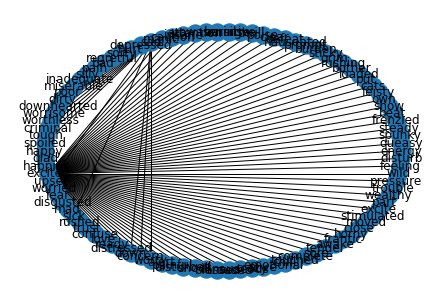

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(emotionRelevanceWeight[0:100], 'node0', 'node1', edge_attr = 'weight')

nx.draw_shell(G, with_labels=True)

In [32]:
df = emotionRelevanceWeight
df

,Unnamed: 0,from,to,weight
0,0,happy,glad,2
1,1,happy,happier,2
2,2,excited,upset,4
3,3,excited,worried,4
4,4,excited,fear,4
...,...,...,...,...
26821,26821,represented,try,4
26822,26822,spirit,objective,4
26823,26823,vague,promiscuous,4
26824,26824,objective,packed,4


{('happy', 'glad'): Text(-0.23491254038908455, -0.9567521883714271, '2'),
 ('happy', 'happier'): Text(-0.2613604453762459, -0.9717725150059147, '2'),
 ('excited', 'upset'): Text(0.019969541426198816, 0.026266843023404166, '4'),
 ('excited', 'worried'): Text(-0.026005226675579377, 0.07589779402837152, '4'),
 ('excited', 'fear'): Text(-0.05765932498422932, 0.07325528923743016, '4'),
 ('excited',
  'disgusted'): Text(-0.029800227727257128, 0.020521620883352923, '4'),
 ('excited', 'mad'): Text(-0.10515397088616123, -0.006104658969119936, '2'),
 ('excited', 'sick'): Text(0.029053063073149903, 0.02422331022748673, '3'),
 ('excited',
  'rushed'): Text(-0.061315005818813675, 0.0076110855401718275, '4'),
 ('excited', 'trust'): Text(-0.010587402916174892, 0.04880704298856252, '4'),
 ('excited', 'confuse'): Text(-0.04279425325963791, 0.017258577756326905, '4'),
 ('excited', 'love'): Text(-0.023536881610315242, 0.04132347014409358, '4'),
 ('excited', 'ready'): Text(-0.015289855705121121, 0.0112507

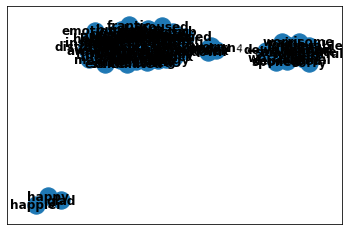

In [52]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [48]:
import matplotlib.pyplot as plt
df = emotionRelevanceWeight
plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_edgelist(df, source='node0', target='node1') 

# g.nodes()
# [g.degree(node) for node in g.nodes() if node in df.node1]
g.degree('happy')

2

<Figure size 864x864 with 0 Axes>